#### I. Referencias consultadas

Algebra lineal
+ [Distintas formas de invertir matrices en Julia](https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)

Libería Gridap
+ [Domain Contributions](https://github.com/gridap/Gridap.jl/blob/ba78d8d34207b318dab7251617bdc310f6be26fc/src/CellData/DomainContributions.jl#L2)
+ [MultiField](https://github.com/gridap/Gridap.jl/tree/ba78d8d34207b318dab7251617bdc310f6be26fc/src/MultiField)
+ [FESpaces](https://github.com/gridap/Gridap.jl/tree/ba78d8d34207b318dab7251617bdc310f6be26fc/src/FESpaces)
+ [Tutorials](https://gridap.github.io/Tutorials/dev/)
+ [Community](https://gitter.im/Gridap-jl/community)

Libreria Arpack
+ [API Arpack.eigs](https://arpack.julialinearalgebra.org/stable/api/)
+ [Arpack](https://docs.juliahub.com/Arpack/X5VZL/0.4.0/#lib-itereigen-1)
+ [Eigen value problems](https://doc.freefem.org/models/eigen-value-problems.html)

Libreria SLEPc
+ [GridapPETSc](https://github.com/gridap/GridapPETSc.jl)
+ [Julia wrapper for SLEPc library](https://discourse.julialang.org/t/julia-wrapper-for-slepc-library/54910)
+ [Parallel Julia wrapper for SLEPc library](https://juliahub.com/ui/Packages/SlepcWrap/S3PC8/0.1.2)

Teoría
+ [Gram-Schmidt Procedure](https://tlienart.github.io/posts/2021/06/25-gram-schmidt/)

# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el problema de autovalores

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [1]:
include("../modules/module_schrodinger_equation_testing_02.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


VARIABLES GLOBALES:
m=1.0000 (mass)
ω=1.0000 (frecuency)
ħ=1.0000 (Planck constant)
γ=0.1000 (coupling)


x₁=0.0000 x₂=2.0000 (QHO origin position)


## 2. Creamos propiedades de la grilla

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [2]:
grid_type="simple_line";                            # tipo de grilla
ΔxH=1.0/1500.0;                                      # tamaño del elento 1D
# ΔxH=1.0/800.0;

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0338657s, CPU 0.032451s)
Info    : 75001 nodes 75002 elements
Info    : Writing '../outputs/Output_Testing_02_TotalEigenProblemAndEvolution/models/simple_line_01.msh'...
Info    : Done writing '../outputs/Output_Testing_02_TotalEigenProblemAndEvolution/models/simple_line_01.msh'
Info    : Reading '../outputs/Output_Testing_02_TotalEigenProblemAndEvolution/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 75001 nodes
Info    : 75002 elements
Info    : Done reading '../outputs/Output_Testing_02_TotalEigenProblemAndEvolution/models/simple_line_01.msh'


Creamos una función para obtener los puntos discretos de la grilla (valuados) y un vector de dichos puntos, lo cual será útil para graficar los resultados o realizar cálculos específicos

In [3]:
function space_coord(dom,Δx)
    x=[dom[1]+abs(dom[2]-dom[1])*Δx*i for i in 1:convert(Int,1.0/Δx)];
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/ΔxH)];
    return x,pts;
end

space_coord (generic function with 1 method)

In [4]:
x,pts=space_coord(dom_1D,ΔxH);

## 3. Segundo método

La idea acá es resolver el problema de autovalores para los hamiltonianos $\hat {h}(x)$ y $\hat {H}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

El sistema se reduce a una ecuación de Sturm-Liouville con parámetros $p( x) ,q( x) ,r( x)$ defnidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q( x) =\frac{1}{2} m\omega ^{2}( x-x_{a})^{2}\\
    r( x) =1
    \end{cases} \Rightarrow -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}
\end{align}

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales

Las formas bilineales para considerar el problema débil de autovalores serán de la forma,

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}( u_{1} ,v_{1}) := \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q( x)( v_{1} u_{1})] d\Omega \\
    a_{2}( u_{2} ,v_{2}) := \int _{\Omega }[ p( x)( \nabla v_{2} \cdotp \nabla u_{2}) +q( x)( v_{2} u_{2})] d\Omega 
    \end{cases}\\
    a(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := a_{1}( u_{1} ,v_{1}) +a_{2}( u_{2} ,v_{2})\\
    \\
    \begin{cases}
    b_{1}( u_{1} ,v_{1}) := \int _{\Omega } r( x)( v_{1} u_{1}) d\Omega ; & b_{2}( u_{2} ,v_{2}) := \int _{\Omega } r( x)( v_{2} u_{2}) d\Omega 
    \end{cases}\\
    b(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := b_{1}( u_{1} ,v_{1}) +b_{2}( u_{2} ,v_{2})
    \end{array}
\end{align}

In [5]:
Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);

aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D);

Construimos el problema de autovalores, con parámetros específicos de resolución

In [6]:
nevₕ=40; # debe ser múltiplo de 2
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0);

Resolvermos el problema, para obtener autovalores y autoestados

In [7]:
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un único autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneración) los datos obtenidos para no duplicar resultados y quedarnos con sólo aquellos resultados no triviales.

In [8]:
Vₕreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕreim_1D=TrialFESpace(Vₕreim_1D,dirichlet_values_1D);

ϕₕreim_1D=Vector{CellField}(undef,convert(Int32,probₕ_1D.nev/2));

for i in 1:2:probₕ_1D.nev
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[i],probₕ_1D.trial);
    fₕre_1D,fₕim_1D=fₕ_1D;
    ϕₕreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere(fₕre_1D+im*fₕim_1D,Uₕreim_1D);
end

Creamos una función que arroja un vector de valores, donde cada elemento será el resultado de la norma de un autoestado de $\hat {h}_{x_0=0}(x)$

In [9]:
function normalization_eigenstates_1D(ϕ,TrialSpace,dΩ)
    nom_vec=zeros(Float64,length(ϕ))
    for i in 1:length(ϕ)
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        nom_vec[i]=norm_L2(ϕ[i],dΩ)
    end
    return nom_vec;
end

normalization_eigenstates_1D (generic function with 1 method)

Verificamos la normalización de los autoestados, para ello usando la función anterior y deberíamos obtener resultados cercanos a la unidad

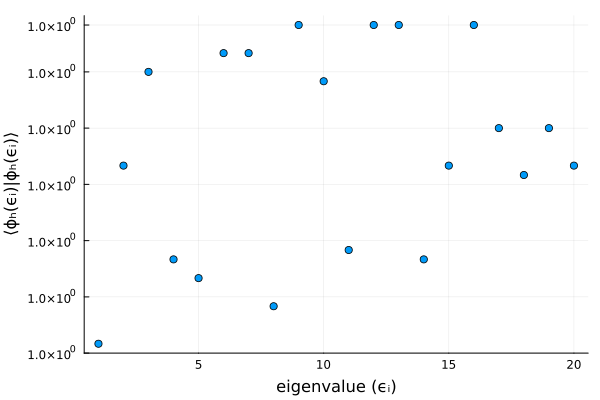

In [45]:
plotting=false
if plotting
    ϕₕreim_1D_norm=normalization_eigenstates_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕₕreim_1D)],ϕₕreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕₕ(ϵᵢ)|ϕₕ(ϵᵢ)⟩")
    display(plot₁)
end

Ahora podemos graficar los diferentes autoestados

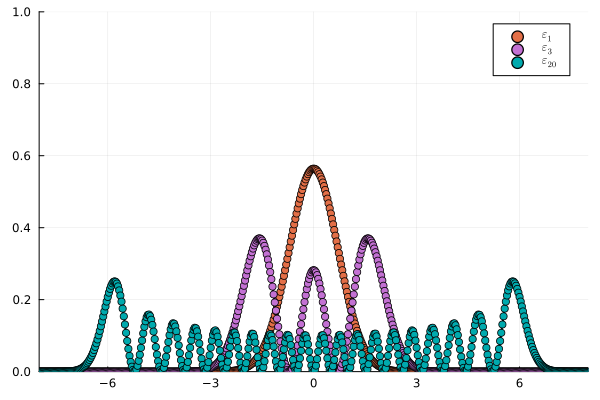

In [11]:
plotting=false
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,3,20]
        ρₕreim_1D=real(conj(ϕₕreim_1D[i].(pts)).*(ϕₕreim_1D[i].(pts)))
        plot1=plot!(x,ρₕreim_1D,label="",lw=2,lc=:"black",ylim=(0,1),xlim=(-8,8))
        plot1=scatter!(x,ρₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,1),xlim=(-8,8))
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_eigenstates_QHO_individual.pdf");
end

De la misma forma que para los autoestados debemos retener sólo algunos resultados de los autovalores obtenidos, recordando la degeneración de las partes real e imaginaria asociadas a un mismo autoestado.

In [10]:
ϵₕ₁re_1D=ϵₕ_1D[1:2:end]; # vector de autoestados (SIN DEGENERACIÓN)

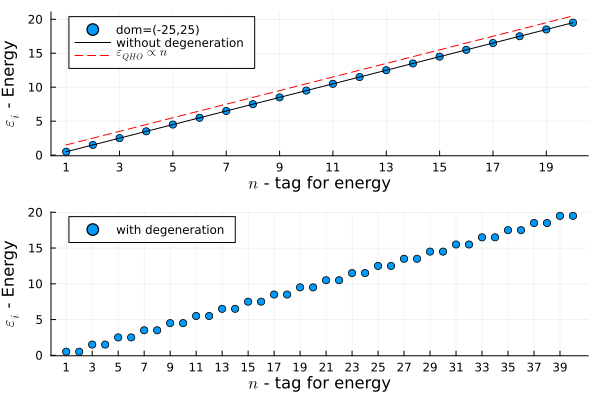

In [13]:
plotting=false
if plotting
    plot1=scatter([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot1=plot!([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!([i for i in 1:nevₕ/2],(ħ*ω).*([i for i in 1:nevₕ/2].+0.5),label="\$\\epsilon_{QHO} \\propto n\$",lc=:"red",lw=1,ls=:dash);
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevₕ],ϵₕ_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot3,path_plots*"eigenvalues_QHO_individual.pdf");
    display(plot3)
end

### 3.2. Resolvemos problema de autovalores para $\hat {H}(x)$

Tendremos que resolver el siguiente sistema (en formato matricial) $A\vec{u} =\lambda \vec{u}$ donde

\begin{align}
    A := \begin{pmatrix}
    -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{1}( x) & 0 & s( x) & 0\\
    0 & -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{1}( x) & 0 & s( x)\\
    s( x) & 0 & -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{2}( x) & 0\\
    0 & s( x) & 0 & -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{2}( x)
    \end{pmatrix}
\end{align}

\begin{align}
    \vec{u} := \begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)\\
    u_{3}( x)\\
    u_{4}( x)
    \end{pmatrix}
\end{align}

Las formas bilineales para considerar el problema débil de autovalores serán de la forma,

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}(( u_{1} ,u_{3}) ,v_{1}) := \int _{\Omega }[ p( \nabla v_{1} \cdotp \nabla u_{1}) +q_{1} v_{1} u_{1} +sv_{1} u_{3}] d\Omega \\
    a_{2}(( u_{2} ,u_{4}) ,v_{2}) := \int _{\Omega }[ p( \nabla v_{2} \cdotp \nabla u_{2}) +q_{1} v_{2} u_{2} +sv_{2} u_{4}] d\Omega \\
    a_{3}(( u_{3} ,u_{1}) ,v_{3}) := \int _{\Omega }[ p( \nabla v_{3} \cdotp \nabla u_{3}) +q_{2} v_{3} u_{3} +sv_{3} u_{1}] d\Omega \\
    a_{4}(( u_{4} ,u_{2}) ,v_{4}) := \int _{\Omega }[ p( \nabla v_{4} \cdotp \nabla u_{4}) +q_{2} v_{4} u_{4} +sv_{4} u_{2}] d\Omega 
    \end{cases}\\
    a(( u_{1} ,u_{2} ,u_{3} ,u_{4}) ,( v_{1} ,v_{2} ,v_{3} ,v_{4})) := \sum\nolimits _{i=1}^{4} a_{i}(( u_{i} ,u_{j}) ,v_{i})\\
    \\
    \begin{cases}
    b_{1}(( u_{1} ,v_{1})) := \int _{\Omega } rv_{1} u_{1} d\Omega ; & b_{2}(( u_{2} ,v_{2})) := \int _{\Omega } rv_{2} u_{2} d\Omega \\
    b_{3}(( u_{3} ,v_{3})) := \int _{\Omega } rv_{3} u_{3} d\Omega ; & \ b_{4}(( u_{4} ,v_{4})) := \int _{\Omega } rv_{4} u_{4} d\Omega 
    \end{cases}\\
    b(( u_{1} ,u_{2} ,u_{3} ,u_{4}) ,( v_{1} ,v_{2} ,v_{3} ,v_{4})) := \sum\nolimits _{i=1}^{4} b_{i}(( u_{i} ,v_{i}))
    \end{array}
\end{align}

entonces todo se resume a resolver un problema del tipo,

\begin{align}
    a(( u_{1} ,u_{2} ,u_{3} ,u_{4}) ,( v_{1} ,v_{2} ,v_{3} ,v_{4})) =\lambda b(( u_{1} ,u_{2} ,u_{3} ,u_{4}) ,( v_{1} ,v_{2} ,v_{3} ,v_{4}))
\end{align}

Observación: Notemos que para construir, por ejemplo, la forma bilineal $a_1$ elegimos una única función arbitraria $v_{1} \in H_{2}$ para integrar la primera ecuación fuerte (primera fila de la matriz $A$) e integrar en todo el dominio de elementos finitos $\Omega$. Es decir, elegimos una única función arbitraria $v_{1} \in H_{2}$ asociada a la funciones $\{u_{1} ,u_{2} ,u_{3}\} \in L_{2}$.

Definimos espacios Test y Trial reales y creamos un `MultiFieldFESpace()` para el sistema $4 \times 4$

In [11]:
V₁reH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁reH_1D=TrialFESpace(V₁reH_1D,dirichlet_values_1D);
V₁imH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁imH_1D=TrialFESpace(V₁imH_1D,dirichlet_values_1D);

V₂reH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂reH_1D=TrialFESpace(V₂reH_1D,dirichlet_values_1D);
V₂imH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂imH_1D=TrialFESpace(V₂imH_1D,dirichlet_values_1D);

UH_1D=MultiFieldFESpace([U₁reH_1D,U₁imH_1D,U₂reH_1D,U₂imH_1D]);
VH_1D=MultiFieldFESpace([V₁reH_1D,V₁imH_1D,V₂reH_1D,V₂imH_1D]);

aH_1D,bH_1D=bilineal_forms_eigenprob_H_ReImParts(pH,qH₁,qH₂,rH,sH,dΩ_1D);

Definimos el problema con parámetros específicos de resolución

In [12]:
nevH=60; # debe ser multiplo de 2 (y, si quiero 10 autovalores debo poner nevH=2⋅10=20)
probH_1D=EigenProblem(aH_1D,bH_1D,VH_1D,UH_1D;nev=nevH,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0);

Resolvemos el problema de autovalores

In [13]:
ϵH_1D,ϕH_1D=solve(probH_1D);

Ahora unimos parte real e imaginaria para formar autoestados complejos

In [14]:
V₁reimH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁reimH_1D=TrialFESpace(V₁reimH_1D,dirichlet_values_1D);
V₂reimH_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂reimH_1D=TrialFESpace(V₂reimH_1D,dirichlet_values_1D);
UHreim_1D=MultiFieldFESpace([U₁reimH_1D,U₂reimH_1D]);
VHreim_1D=MultiFieldFESpace([V₁reimH_1D,V₂reimH_1D]);

# definimos grado de degeneración
deg=2 # (1,2,4,etc)
ϕHreim_1D=Vector{CellField}(undef,convert(Int32,probH_1D.nev/deg));

for i in 1:deg:probH_1D.nev
    fH_1D=interpolate_everywhere(ϕH_1D[i],probH_1D.trial);
    f₁Hre_1D,f₁Him_1D,f₂Hre_1D,f₂Him_1D=fH_1D;
    ϕHreim_1D[convert(Int32,(i+deg-1)/deg)]=interpolate_everywhere([f₁Hre_1D+im*f₁Him_1D,f₂Hre_1D+im*f₂Him_1D],UHreim_1D);
end

Chequeamos normalización de los autoestados

In [15]:
function normalization_eigenstates_2D(ϕ,TrialSpace,dΩ)
    nom_vec₁₂=zeros(Float64,length(ϕ))
    for i in 1:length(ϕ)
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        norm_ϕ¹ᵢ=norm_L2(ϕ¹ᵢ,dΩ)
        norm_ϕ²ᵢ=norm_L2(ϕ²ᵢ,dΩ)
        nom_vec₁₂[i]=norm_ϕ¹ᵢ+norm_ϕ²ᵢ
    end
    return nom_vec₁₂;
end

normalization_eigenstates_2D (generic function with 1 method)

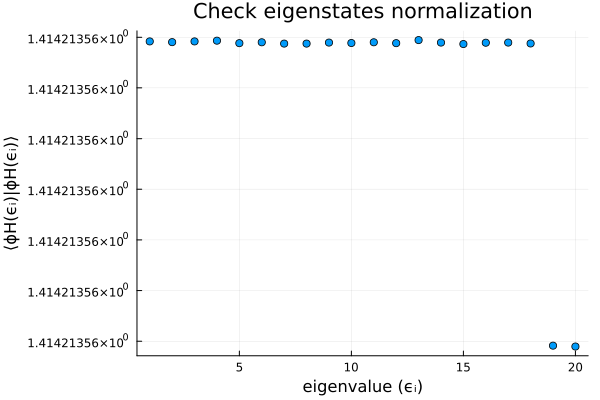

GKS: Possible loss of precision in routine SET_WINDOW


In [86]:
plotting=false
if plotting
    ϕHreim_1D_norm=normalization_eigenstates_2D(ϕHreim_1D,UHreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕHreim_1D)],ϕHreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕH(ϵᵢ)|ϕH(ϵᵢ)⟩")
    plot₁=plot!(title="Check eigenstates normalization")
    display(plot₁)
end

Con el resultado anterior vemos que la normalización de los estados no es $1$ sino que debemos normalizar como normalizariamos un spinor es decir, multiplicando por un factor de $\frac {1}{\sqrt{2}}$

In [16]:
# normalizamos los autoestados en caso de que no lo estén
norm_switch=true
if norm_switch
    ϕHreim_1D_norm=normalization_eigenstates_2D(ϕHreim_1D,UHreim_1D,dΩ_1D);

    for i in 1:length(ϕHreim_1D)
        ϕHreim_1Dᵢ=interpolate_everywhere(ϕHreim_1D[i],UHreim_1D);
        ϕHreim_1D¹ᵢ,ϕHreim_1D²ᵢ=ϕHreim_1Dᵢ;
        ϕHreim_1D[i]=interpolate_everywhere([ϕHreim_1D¹ᵢ/ϕHreim_1D_norm[i],ϕHreim_1D²ᵢ/ϕHreim_1D_norm[i]],UHreim_1D)
    end
end

Chequeamos ortogonalidad entre autoestados

In [17]:
function OrthoCheck_2D(ϕ,TrialSpace,dΩ)
    nev=length(ϕ)
    OrthoVector=zeros(Float64,nev^2-nev);
    index=1
    for i in 1:nev
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        for j in 1:nev
            if (i ≠ j)
                ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
                ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
                OrthoVector[index]=abs(sum(∫(ϕ¹ⱼ'*ϕ¹ᵢ)*dΩ)+sum(∫(ϕ²ⱼ'*ϕ²ᵢ)*dΩ))
                index+=1
            end
        end
    end

    return OrthoVector;
end

OrthoCheck_2D (generic function with 1 method)

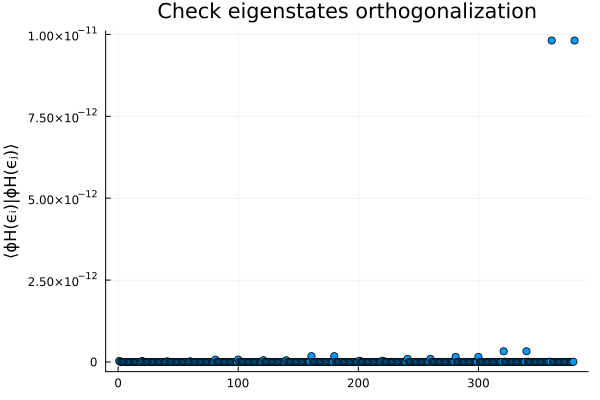

In [53]:
plotting=false
if plotting
    ϕHreim_1D_ortho=OrthoCheck_2D(ϕHreim_1D,UHreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!(ϕHreim_1D_ortho,label="")
    plot₁=plot!(xlabel="",ylabel="⟨ϕH(ϵᵢ)|ϕH(ϵⱼ)⟩")
    plot₁=plot!(title="Check eigenstates orthogonalization")
    display(plot₁)
end

Graficamos autoestados del hamiltoniano completo $\hat {H} (x)$

Ploteamos para cuando $\gamma \neq 0$

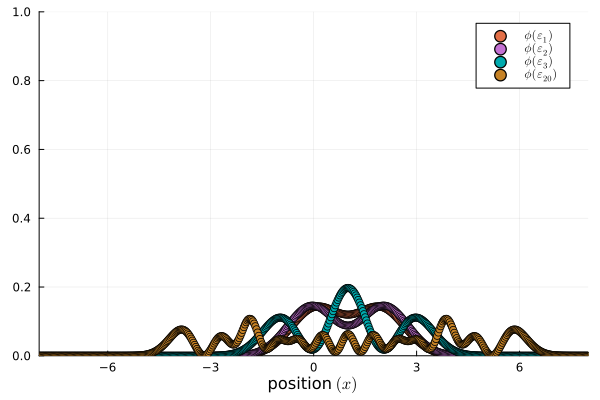

In [88]:
plotting=true
plt=plot();

    for i in [1,2,3,20]
        ρ₁Hreim_1D=real(conj(ϕHreim_1D[i][1].(pts)).*ϕHreim_1D[i][1].(pts))
        ρ₂Hreim_1D=real(conj(ϕHreim_1D[i][2].(pts)).*ϕHreim_1D[i][2].(pts))
        plot1=plot!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="",lw=1,lc=:"black")
        plot1=scatter!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="\$ \\phi(\\epsilon_{$(i)})\$",lw=2,ylim=(0,1),xlim=(-8,8))
    end

    plot1=plot!(xlabel="position \$(x)\$",ylabel="")

    plot3=plot(plot1);
    display(plot3);
    # savefig(plot3,path_plots*"density_eigenstates_totalsystem_withgamma.pdf");

Ploteamos para cuando $\gamma=0$

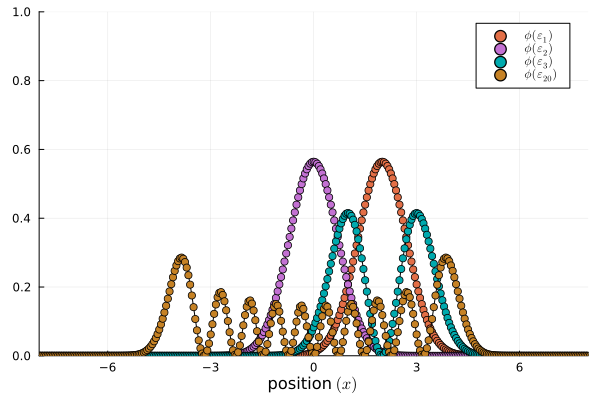

In [44]:
plotting=false
if plotting
    plt=plot();

    for i in [1,2,3,20]
        ρ₁Hreim_1D=real(conj(ϕHreim_1D[i][1].(pts)).*ϕHreim_1D[i][1].(pts))
        ρ₂Hreim_1D=real(conj(ϕHreim_1D[i][2].(pts)).*ϕHreim_1D[i][2].(pts))
        plot1=plot!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="",lw=1,lc=:"black")
        plot1=scatter!(plt,x,(ρ₁Hreim_1D+ρ₂Hreim_1D),label="\$ \\phi(\\epsilon_{$(i)})\$",lw=2,ylim=(0,1),xlim=(-8,8))
    end

    plot1=plot!(xlabel="position \$(x)\$",ylabel="")

    plot3=plot(plot1);
    display(plot3);
    # savefig(plot3,path_plots*"density_eigenstates_totalsystem_withoutgamma.pdf");
end

Y hacemos lo mismo con los autovalores

In [18]:
ϵHre_1D=ϵH_1D[1:deg:end];
n=[i for i in 1:nevH/deg];

Ploteamos para cuando $\gamma = 0$

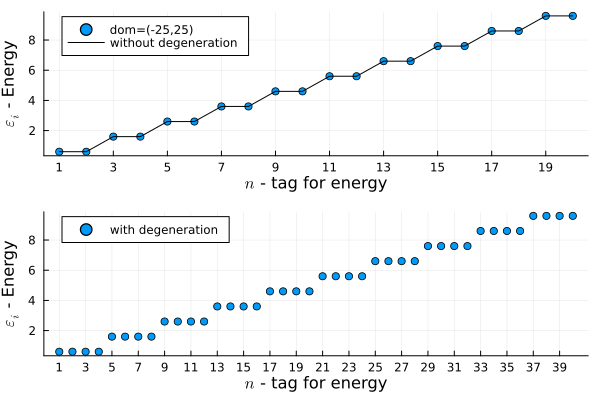

In [46]:
plotting=false
if plotting
    plot1=scatter(n,ϵHre_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevH),lw=2)
    plot1=plot!(n,ϵHre_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevH],ϵH_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevH),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot2,path_plots*"eigenvalues_totalsystem_withoutgamma.pdf");
    display(plot3)
end

Ploteamos para cuando $\gamma \neq 0$

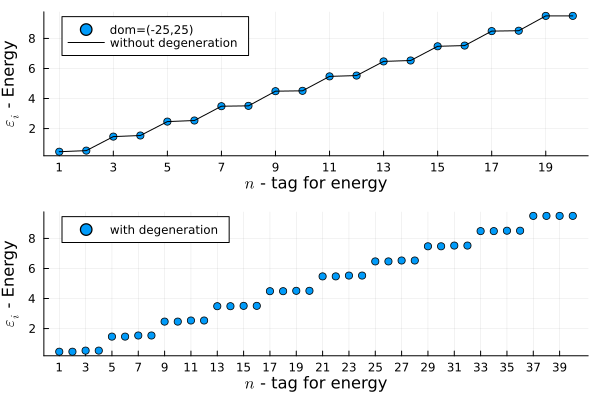

In [22]:
plotting=false
if plotting
    plot1=scatter(n,ϵHre_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevH),lw=2)
    plot1=plot!(n,ϵHre_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevH],ϵH_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevH),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot3,path_plots*"eigenvalues_totalsystem_withgamma.pdf");
    display(plot3)
end

## 4. Segundo método (NO FUNCIONA)

La idea acá es resolver nuevamente el problema de autovalores para los hamiltonianos $\hat {h}(x)$ y $\hat {H}(x)$. Los espacios Test y Trial son complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados de forma conjunta. 

Tenemos un sistema de ecuaciones de tipo Sturm-Liovulle con parámetros $p( x) ,q( x) ,r( x)$ definidos como,

\begin{align}
    \begin{array}{l}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q_{1}( x) =\frac{1}{2} m\omega ^{2}( x-x_{a})^{2} ;q_{2}( x) =\frac{1}{2} m\omega ^{2}( x-x_{b})^{2}\\
    r( x) =1;\ s( x) =\gamma 
    \end{cases}\\
    \\
    \Rightarrow \begin{pmatrix}
    \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{1}( x)\right] & s( x)\\
    s( x) & \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{2}( x)\right]
    \end{pmatrix}\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}\\
    \Rightarrow \begin{cases}
    \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{1}( x)\right] u_{1}( x) +s( x) u_{2}( x) =\lambda r( x) u_{1}( x)\\
    \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q_{2}( x)\right] u_{2}( x) +s( x) u_{1}( x) =\lambda r( x) u_{2}( x)
    \end{cases}
    \end{array}
\end{align}

Las formas bilineales dobles para considerar el problema débil de autovalores serán de la forma

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}(( u_{1} ,u_{2}) ,v_{1}) := \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q_{1}( x) v_{1} u_{1} +s( x) v_{1} u_{2}] d\Omega \\
    a_{2}(( u_{2} ,u_{1}) ,v_{2}) := \int _{\Omega }[ p( x)( \nabla v_{2} \cdotp \nabla u_{2}) +q_{2}( x) v_{2} u_{2} +s( x) v_{2} u_{1}] d\Omega 
    \end{cases}\\
    \\
    \Rightarrow a(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := a_{1}(( u_{1} ,u_{2}) ,v_{1}) +a_{2}(( u_{2} ,u_{1}) ,v_{2})\\
    \\
    \begin{cases}
    b_{1}( u_{1} ,v_{1}) := \int _{\Omega } r( x)( u_{1} v_{1}) d\Omega ; & b_{2}( u_{2} ,v_{2}) := \int _{\Omega } r( x)( u_{2} v_{2}) d\Omega 
    \end{cases}\\
    \Rightarrow b(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := b_{1}( u_{1} ,v_{1}) +b_{2}( u_{2} ,v_{2})
    \end{array}
\end{align}

Si queremos resolver el problema en un espacio complejo, funciona todo bien para el problema de autovalores de $\hat {h}(x)$ pero no para el problema de autovalores de $\hat {H}(x)$

ESTO FUNCIONA

In [135]:
runcomplx=false;
if runcomplx
    Vₕcomplx_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕcomplx_1D=TrialFESpace(Vₕcomplx_1D,dirichlet_values_1D);
    aₕcomplx_1D,bₕcomplx_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);
    probₕcomplx_1D=EigenProblem(aₕcomplx_1D,bₕcomplx_1D,Uₕcomplx_1D,Vₕcomplx_1D;nev=20,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0);
    ϵₕcomplx_1D,ϕₕcomplx_1D=solve(probₕcomplx_1D);
end

In [136]:
runcomplx=false;
if runcomplx
    # espacio de pruebas y de soluciones para ψ₁
    V₁Hcomplx_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    U₁Hcomplx_1D=TrialFESpace(V₁Hcomplx_1D,dirichlet_values_1D);
    # espacio de pruebas y de soluciones para ψ₂
    V₂Hcomplx_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    U₂Hcomplx_1D=TrialFESpace(V₂Hcomplx_1D,dirichlet_values_1D);
    # creamos un campo de espacios
    UHcomplx_1D = MultiFieldFESpace([U₁Hcomplx_1D,U₂Hcomplx_1D]);
    VHcomplx_1D = MultiFieldFESpace([V₁Hcomplx_1D,V₂Hcomplx_1D]);

    aHcomplx_1D,bHcomplx_1D=bilineal_forms_eigenprob_H(pH,qH₁,qH₂,rH,sH,dΩ_1D);
end

ESTO NO FUNCIONA
Arroja el siguiente error
```
MethodError: Cannot `convert` an object of type 
  Gridap.Fields.ArrayBlock{Array{ComplexF64,1},1} to an object of type 
  Gridap.Fields.ArrayBlock{Array{Float64,1},1}
```

In [134]:
# nevH=20;probHcomplx_1D=EigenProblem(aHcomplx_1D,bHcomplx_1D,UHcomplx_1D,VHcomplx_1D;nev=nevH,which=:LI,tol=10^(-9),maxiter=500,explicittransform=:none,sigma=-1.0)

In [19]:
# ϵHcomplx_1D,ϕHcomplx_1D=solve(probHcomplx_1D);

## 5. Resolución de la parte temporal de la ecuación de Schrödinger (evolución)

La evolución se podrá escribir como

\begin{align}
    \ket{\psi ( t)} =\sum _{n=1}^{\infty } c_{n}\exp\left(\frac{-iE_{n} t}{\hbar }\right)\ket{\phi _{n}} =e^{\left(\tfrac{-i}{\hbar } t\right)}\left( c_{1} e^{E_{1}}\ket{\phi _{n}} +c_{2} e^{E_{2}}\ket{\phi _{2}} +\dotsc +c_{n} e^{E_{n}}\ket{\phi _{n}}\right)
\end{align}

Entonces, conocidos los autoestados del hamiltoniano del sistema $\hat {H}(x)$, podremos evolucionar el sistema. Para esto primeramente debemos encontrar cómo se descompone el estado inicial en la base de autoestados de $\hat {H}(x)$.

### 5.1 Funciones útiles para el caso en que $\gamma=0$ (sin acoplamiento)

Creamos una función para recolectar datos del problema de autovalores. Construimos matriz donde cada columna corresponde a un autoestado de $\hat {H}(x)$ y donde cada fila corresponde a dicho autoestado valuado en un punto de la grilla

In [18]:
function eigendata_multifield(ϵ,ϕ,pts,TrialSpace)

    dim_pts=length(pts);
    nev=length(ϕ);

    Heigenvecs₁=zeros(ComplexF64,dim_pts,nev);
    Heigenvecs₂=copy(Heigenvecs₁);
    for i in 1:nev
        fH=interpolate_everywhere(ϕ[i],TrialSpace);
        f₁H,f₂H,=fH;
        Heigenvecs₁[:,i]=f₁H.(pts);
        Heigenvecs₂[:,i]=f₂H.(pts);
    end

    Heigenvals=copy(ϵ);
    return Heigenvals,Heigenvecs₁,Heigenvecs₂;
end

eigendata_multifield (generic function with 1 method)

Funciones para determinar coeficientes que permiten escribir la condición inicial como combinación lineal de autoestados

De forma generalizada tendremos,

\begin{align}
    \circ \equiv \begin{pmatrix}
    \begin{pmatrix}
    \phi _{1}^{1}( x_{1}) & \phi _{2}^{1}( x_{1}) & \dotsc  & \phi _{n}^{1}( x_{1})\\
    \phi _{1}^{1}( x_{2}) & \phi _{2}^{1}( x_{2}) &  & \phi _{n}^{1}( x_{2})\\
    \vdots  & \vdots  & \ddots  & \vdots \\
    \phi _{1}^{1}( x_{m}) & \phi _{2}^{2}( x_{m}) &  & \phi _{n}^{2}( x_{m})
    \end{pmatrix}\\
    \begin{pmatrix}
    \phi _{1}^{2}( x_{1}) & \phi _{2}^{2}( x_{1}) & \dotsc  & \phi _{n}^{2}( x_{1})\\
    \phi _{1}^{2}( x_{2}) & \phi _{2}^{2}( x_{2}) &  & \phi _{n}^{2}( x_{2})\\
    \vdots  & \vdots  & \ddots  & \vdots \\
    \phi _{1}^{2}( x_{m}) & \phi _{2}^{2}( x_{m}) &  & \phi _{n}^{2}( x_{m})
    \end{pmatrix}
    \end{pmatrix}\begin{pmatrix}
    ( c_{1})^{*}\\
    ( c_{2})^{*}\\
    \vdots \\
    ( c_{n})^{*}
    \end{pmatrix} =\begin{pmatrix}
    \begin{pmatrix}
    \psi _{0}^{1}( x_{1})\\
    \psi _{0}^{1}( x_{2})\\
    \vdots \\
    \psi _{0}^{1}( x_{m})
    \end{pmatrix}\\
    \begin{pmatrix}
    \psi _{0}^{2}( x_{1})\\
    \psi _{0}^{2}( x_{2})\\
    \vdots \\
    \psi _{0}^{2}( x_{m})
    \end{pmatrix}
    \end{pmatrix}
\end{align}

Tenemos dos funciones porque `CoeffInitCond₁(...)` sirve para obtener los coeficientes del estado inicial (función que recibe un vector de FE) y `CoeffInitCond₂(...)` sirve para obtener los coeficientes en cada paso evolucionado (función que recibe las componentes de un vector valuadas en cada punto de la grilla)

In [19]:
function CoeffInitCond₁(𝛹₀,pts,Heigenvecs₁,Heigenvecs₂)

    dimrows=convert(Int32,2*length(Heigenvecs₁[:,1]))
    dimcol=length(Heigenvecs₁[1,:])

    Heigenvecs₁₂=zeros(ComplexF64,dimrows,dimcol); # creamos matriz de componentes de eigenvectors
    Heigenvecs₁₂[1:length(Heigenvecs₁[:,1]),:]=Heigenvecs₁
    Heigenvecs₁₂[convert(Int32,length(Heigenvecs₁[:,1])+1):end,:]=Heigenvecs₂

    𝛹¹₀,𝛹²₀=𝛹₀;

    InnerProdBC=zeros(ComplexF64,dimrows); # creamos vector de componentes del vector estado inicial
    InnerProdBC[1:length(Heigenvecs₁[:,1])]=𝛹¹₀.(pts);
    InnerProdBC[convert(Int32,length(Heigenvecs₁[:,1])+1):end]=𝛹²₀.(pts);

    # 1er método para invertir matrices
    adjcoeffvec₁₂=conj(InnerProdBC)\Heigenvecs₁₂; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    # 2do método para invertir matrices (MENOS PRECISO https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)
    # adjcoeffvec₁₂=pinv(Heigenvecs₁₂)*conj(InnerProdBC);

    return adjoint(adjcoeffvec₁₂);
end

function CoeffInitCond₂(𝛹¹₀,𝛹²₀,Heigenvecs₁,Heigenvecs₂)

    dimrows=convert(Int32,2*length(Heigenvecs₁[:,1]))
    dimcol=length(Heigenvecs₁[1,:])

    Heigenvecs₁₂=zeros(ComplexF64,dimrows,dimcol); # creamos matriz de componentes de eigenvectors
    Heigenvecs₁₂[1:length(Heigenvecs₁[:,1]),:]=Heigenvecs₁
    Heigenvecs₁₂[convert(Int32,length(Heigenvecs₁[:,1])+1):end,:]=Heigenvecs₂
    𝛹¹₀
    InnerProdBC=zeros(ComplexF64,dimrows); # creamos vector de componentes del vector estado inicial
    InnerProdBC[1:length(Heigenvecs₁[:,1])]=𝛹¹₀;
    InnerProdBC[convert(Int32,length(Heigenvecs₁[:,1])+1):end]=𝛹²₀;

    # 1er método para invertir matrices
    adjcoeffvec₁₂=conj(InnerProdBC)\Heigenvecs₁₂; # InnerProdBC≡⟨InnerProdBC(x)| son vectores columna

    # 2do método para invertir matrices (MENOS PRECISO https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)
    # adjcoeffvec₁₂=pinv(Heigenvecs₁₂)*conj(InnerProdBC);

    return adjoint(adjcoeffvec₁₂);
end

CoeffInitCond₂ (generic function with 1 method)

### 5.2 Funciones útiles para el caso en que $\gamma \neq 0$ (con acoplamiento)

In [19]:
# Inner product in L₂
function InnerProduct(ϕ₁vec,ϕ₂vec,dΩ)
    return sum(∫(ϕ₁vec'*ϕ₂vec)*dΩ);
    #=
    es necesario calcular la función sum() porque el argumento
    es de tipo DomainContribution() y debemos sumar en cada punto
    de la grilla según la interpolación definida.
    Para más infor ver:
        https://github.com/gridap/Gridap.jl/blob/ba78d8d34207b318dab7251617bdc310f6be26fc/src/CellData/DomainContributions.jl#L2
    =#
end

InnerProduct (generic function with 1 method)

Función para determinar coeficientes que permiten escribir la condición inicial como combinación lineal de autoestados del hamiltoniano

\begin{align}
    \Rightarrow \begin{pmatrix}
    \bra{\phi _{1}}\ket{\psi _{0}}\\
    \bra{\phi _{2}}\ket{\psi _{0}}\\
    \vdots \\
    \bra{\phi _{n}}\ket{\psi _{0}}
    \end{pmatrix} =\begin{pmatrix}
    \bra{\phi _{1}}\ket{\phi _{1}} & \bra{\phi _{1}}\ket{\phi _{2}} & \dotsc  & \bra{\phi _{1}}\ket{\phi _{n}}\\
    \bra{\phi _{2}}\ket{\phi _{1}} & \bra{\phi _{2}}\ket{\phi _{2}} & \dotsc  & \bra{\phi _{2}}\ket{\phi _{n}}\\
    & \vdots  &  & \\
    \bra{\phi _{n}}\ket{\phi _{1}} & \bra{\phi _{n}}\ket{\phi _{2}} & \dotsc  & \bra{\phi _{n}}\ket{\phi _{n}}
    \end{pmatrix}\begin{pmatrix}
    c_{1}\\
    c_{2}\\
    \vdots \\
    c_{n}
    \end{pmatrix} \equiv (\vec{b} =A\vec{x})
\end{align}

entonces podremos encontrar el vector de coeficientes $\vec{x}$ invirtiendo la matriz $A$ y pre-multiplicando la inversa de esta al vector $\vec{b}$ (usando, por ejemplo, el operador `blackslash` $\vec{x} =\vec{A} /\vec{b}$). Aquí cada producto interno se define (numéricamente) como

\begin{align}
    \bra{\phi _{m}}\ket{\phi _{n}} =\mathrm{sum}\left(\int _{\Omega }[ \phi _{m}( x_{i})]^{*} \phi _{n}( x_{j}) d\Omega \right)
\end{align}

Además, la matriz $A$ puede ser optimizada teniendo en cuenta las propiedades de simetría que presenta

\begin{align}
    A=\begin{pmatrix}
    \bra{\phi _{1}}\ket{\phi _{1}} & \bra{\phi _{1}}\ket{\phi _{2}} & \dotsc  & \bra{\phi _{1}}\ket{\phi _{n}}\\
    \left(\bra{\phi _{1}}\ket{\phi _{2}}\right)^{\dagger } & \bra{\phi _{2}}\ket{\phi _{2}} & \dotsc  & \bra{\phi _{2}}\ket{\phi _{n}}\\
    & \vdots  &  & \\
    \left(\bra{\phi _{1}}\ket{\phi _{n}}\right)^{\dagger } & \left(\bra{\phi _{2}}\ket{\phi _{n}}\right)^{\dagger } & \dotsc  & \bra{\phi _{n}}\ket{\phi _{n}}
    \end{pmatrix}
\end{align}

entonces sólo debemos calcular la diagonal principal y la parte triangular superior de la matriz, luego por simetría obtenemos la parte triangular inferior.

In [20]:
function CoeffInitCondOptimized(𝛹₀,TrialSpace,ϕ,dΩ)
    
    𝛹¹₀,𝛹²₀=𝛹₀;
    dim=length(ϕ)

    InnerProdEigenvecs=zeros(ComplexF64,dim,dim);   # matriz global de inversas de productos internos entre autoestados
    InnerProdBC=zeros(ComplexF64,dim);              # vector global de productos internos entre autoestados y estado inicial

    # primer submatriz n✖n y subvector n✖1
    for i in 1:dim
        ϕᵢ=interpolate_everywhere(ϕ[i],TrialSpace);
        ϕ¹ᵢ,ϕ²ᵢ=ϕᵢ
        InnerProdBC[i]=(sum(∫(ϕ¹ᵢ'*𝛹¹₀)*dΩ)+sum(∫(ϕ²ᵢ'*𝛹²₀)*dΩ))
        for j in i:dim
            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ
            InnerProdEigenvecs[i,j]=(sum(∫(ϕ¹ᵢ'*ϕ¹ⱼ)*dΩ)+sum(∫(ϕ²ᵢ'*ϕ²ⱼ)*dΩ))
            if (i≠j) # optimización por simetría
                InnerProdEigenvecs[j,i]=conj(InnerProdEigenvecs[i,j])
            end
        end
    end

    # x=A\b
    coeffvec₁₂=InnerProdEigenvecs\InnerProdBC;

    return coeffvec₁₂;
end

CoeffInitCond₁v₂Optimizedv₆ (generic function with 1 method)

### 5.3 Construimos el estado inicial

Acá definimos el estado fundamental del hamiltoniano $\hat {h}_{x_0=0}(x)$ como una función interpolable que podremos utilizar para construir la condicion inicial del sistema global, gobernado por $\hat {H}(x)$.

In [21]:
u₀ₕ_1D=interpolate_everywhere(ϕₕreim_1D[1],Uₕreim_1D);
interp_u₀ₕ_1D=Interpolable(u₀ₕ_1D);

Acá efectivamente construimos la condición inicial

In [22]:
type_BC=1;
if (type_BC==1)
    u₁0H_1D_v₁(x)=0.0;
    u₂0H_1D_v₁=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[2]);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₁,u₂0H_1D_v₁],UHreim_1D);
elseif (type_BC==2)
    u₁0H_1D_v₂=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[1]);
    u₂0H_1D_v₂(x)=0.0;
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₂,u₂0H_1D_v₂],UHreim_1D);
elseif (type_BC==3)
    u₁0H_1D_v₃=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[1]);
    u₂0H_1D_v₃=interpolate_everywhere(interp_u₀ₕ_1D,UHreim_1D[2]);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₃,u₂0H_1D_v₃],UHreim_1D);
end

MultiFieldFEFunction():
 num_cells: 75000
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 16565883044700046128

Graficamos funciones densidad inicial (para el caso en que `type_BC=1`)

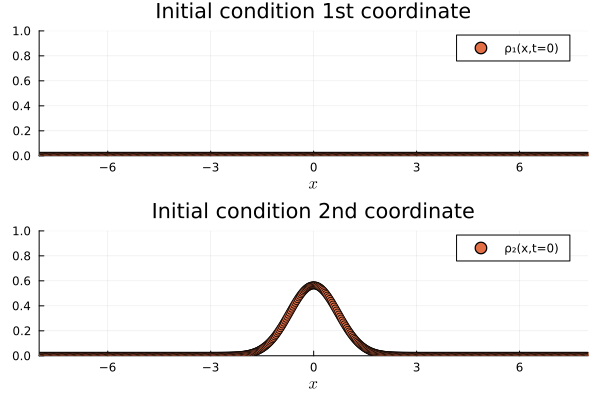

In [27]:
plotting=false
if plotting
    ρ¹₀H_1D=real(conj(u₀H_1D[1].(pts)).*u₀H_1D[1].(pts))
    ρ²₀H_1D=real(conj(u₀H_1D[2].(pts)).*u₀H_1D[2].(pts))

    plot1=plot(x,ρ¹₀H_1D,label="",lw=1,lc=:"black",ylim=(0,1),xlim=(-8,8))
    plot1=scatter!(x,ρ¹₀H_1D,label="ρ₁(x,t=0)",lw=2,ylim=(0,1),xlim=(-8,8),xlabel="\$x\$")
    plot1=plot!(title="Initial condition 1st coordinate")

    plot2=plot(x,ρ²₀H_1D,label="",lw=1,lc=:"black",ylim=(0,1),xlim=(-8,8))
    plot2=scatter!(x,ρ²₀H_1D,label="ρ₂(x,t=0)",lw=2,ylim=(0,1),xlim=(-8,8),xlabel="\$x\$")
    plot2=plot!(title="Initial condition 2nd coordinate")

    plot3=plot(plot1,plot2,layout=(2,1));
    display(plot3);
    # savefig(plot3,path_plots*"density_initialcondition_type01.pdf");
end

### 5.4 Evolución para cuando $\gamma = 0$ (without coupling)

In [89]:
Heigenvals,Heigenvecs₁,Heigenvecs₂=eigendata_multifield(ϵHre_1D,ϕHreim_1D,pts,UHreim_1D);

In [65]:
function evolution_schrodinger(Heigenvals,Heigenvecs₁,Heigenvecs₂,𝛹₀,pts,time_vec)

    dim_time=length(time_vec)
    dim_eigenval=length(Heigenvals)
    dim_position=length(Heigenvecs₁[:,1])

    𝛹₁ₓₜ=zeros(ComplexF64,dim_position,dim_time);
    𝛹₂ₓₜ=zeros(ComplexF64,dim_position,dim_time);

    coeffvec₁₂=CoeffInitCond₁(𝛹₀,pts,Heigenvecs₁,Heigenvecs₂);

    for i in 1:dim_time
        for j in 1:dim_eigenval
            for k in 1:dim_position
                𝛹₁ₓₜ[k,i]=𝛹₁ₓₜ[k,i]+coeffvec₁₂[j]*exp(-im*(1.0/ħ)*Heigenvals[j]*time_vec[i])*Heigenvecs₁[k,j]
                𝛹₂ₓₜ[k,i]=𝛹₂ₓₜ[k,i]+coeffvec₁₂[j]*exp(-im*(1.0/ħ)*Heigenvals[j]*time_vec[i])*Heigenvecs₂[k,j]
            end
        end
        coeffvec₁₂=CoeffInitCond₂(𝛹₁ₓₜ[:,i],𝛹₂ₓₜ[:,i],Heigenvecs₁,Heigenvecs₂);
    end

    return 𝛹₁ₓₜ,𝛹₂ₓₜ;
end

evolution_schrodinger (generic function with 1 method)

In [ ]:
time_vec=[(i-1)*1e-2 for i in 1:1];

In [ ]:
ψ₁t,ψ₂t=evolution_schrodinger(Heigenvals,Heigenvecs₁,Heigenvecs₂,u₀H_1D,pts,time_vec);

### 5.5 Evolución para cuando $\gamma \neq 0$ (with coupling)

In [23]:
function evolution_schrodinger_v₂(ϵ,ϕ,TrialSpace,𝛹₀,time_vec,dΩ)

    dim_time=length(time_vec)
    dim_eigenval=length(ϵ)

    # calculamos los coeficientes de la superposición lineal
    coeffvec₁₂=CoeffInitCondOptimized(𝛹₀,TrialSpace,ϕ,dΩ)

    𝛹ₓₜ=Vector{CellField}(undef,dim_time);

    # inicializamos en cero el vector de onda
    ϕ₁=interpolate_everywhere(ϕ[1],TrialSpace);
    ϕ¹₁,ϕ²₁=ϕ₁;
    for i in 1:dim_time
        𝛹ₓₜ[i]=interpolate_everywhere([0.0*ϕ¹₁,0.0*ϕ²₁],TrialSpace)
    end

    for i in 1:dim_time
        for j in 1:dim_eigenval
            𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[i],TrialSpace)
            𝛹¹ₓₜⁱ,𝛹²ₓₜⁱ=𝛹ₓₜⁱ

            ϕⱼ=interpolate_everywhere(ϕ[j],TrialSpace);
            ϕ¹ⱼ,ϕ²ⱼ=ϕⱼ;
            
            factor=coeffvec₁₂[j]*exp(-im*(1.0/ħ)*ϵ[j]*time_vec[i])
            
            𝛹ₓₜ[i]=interpolate_everywhere([𝛹¹ₓₜⁱ+factor*ϕ¹ⱼ,𝛹²ₓₜⁱ+factor*ϕ²ⱼ],TrialSpace)
        end

        # normalizamos la función de onda luego de cada evolución
        norm_switch=true
        if norm_switch
            Norm𝛹ₓₜ=normalization_eigenstates_2D(𝛹ₓₜ,TrialSpace,dΩ)
            𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[i],TrialSpace)
            𝛹¹ₓₜⁱ,𝛹²ₓₜⁱ=𝛹ₓₜⁱ
            𝛹ₓₜ[i]=interpolate_everywhere([𝛹¹ₓₜⁱ/Norm𝛹ₓₜ[i],𝛹²ₓₜⁱ/Norm𝛹ₓₜ[i]],TrialSpace)
        end

        # calculamos los coeficientes de la superposición lineal
        coeffvec₁₂=CoeffInitCondOptimized(𝛹₀,TrialSpace,ϕ,dΩ)
    end

    return 𝛹ₓₜ;
end

evolution_schrodinger_v₂ (generic function with 1 method)

In [24]:
t_start=0.0;t_end=105;   # tiempos adimensionales inicial y final
num_steps=541;                             # number of time steps or number of points  
n_int_save=27;                                   # Intervals where data is saved n_int_save=n_inf/20=(num_steps-1)/20
Δt=abs(t_end-t_start)*(1.0/(num_steps-1));   # time step

@printf("Δx=%.6f\nΔt=%.6f\n#steps=%.d",ΔxH,Δt,num_steps)

Δx=0.000667
Δt=0.194444
#steps=541

In [25]:
time_vec=[t_start+(i-1)*Δt for i in 1:n_int_save:num_steps]

21-element Vector{Float64}:
   0.0
   5.25
  10.5
  15.75
  21.0
  26.25
  31.5
  36.75
  42.0
  47.25
   ⋮
  63.0
  68.25
  73.5
  78.75
  84.0
  89.25
  94.5
  99.75
 105.0

In [26]:
𝛹ₓₜ=evolution_schrodinger_v₂(ϵHre_1D,ϕHreim_1D,UHreim_1D,u₀H_1D,time_vec,dΩ_1D);

## 8. Resultados obtenidos

### 8.1 Testeamos los métodos para $\gamma = 0$

Para el caso en que la segunda componente de $\psi_{0}$ corresponde a un autoestado de $\hat {h}_{x_{i}=0}$ y la primer componente de $\psi_{0}$ es trivialmente nula, esperamos que la primer componente no evolucione en absoluto y que la segunda componente evolucione como un estado coherente.

In [23]:
function density_prob(𝛹₁ₓₜ,𝛹₂ₓₜ)
    
    dim_space=length(𝛹₁ₓₜ[:,1])
    dim_time=length(𝛹₁ₓₜ[1,:])

    ρ₁ₓₜ=zeros(Float64,dim_space,dim_time);
    ρ₂ₓₜ=zeros(Float64,dim_space,dim_time);

    @. ρ₁ₓₜ=conj(𝛹₁ₓₜ)*𝛹₁ₓₜ
    @. ρ₂ₓₜ=conj(𝛹₂ₓₜ)*𝛹₂ₓₜ
    
    return ρ₁ₓₜ,ρ₂ₓₜ;
end

density_prob (generic function with 1 method)

In [24]:
ρ₁t,ρ₂t=density_prob(ψ₁t,ψ₂t);

([5.800405815620299e-34 5.800389706322538e-34 … 5.800111295795471e-34 5.800095467770281e-34; 2.014070013233178e-34 2.01406542632446e-34 … 2.0143739502592157e-34 2.014369410711419e-34; … ; 3.5475722341163643e-34 3.5475576977166587e-34 … 3.5435173556894328e-34 3.5435022809560333e-34; 0.0 0.0 … 0.0 0.0], [7.384392669357206e-36 7.384417351717147e-36 … 7.407619849087449e-36 7.407645545474023e-36; 2.507657460183705e-35 2.507641295159239e-35 … 2.5017570312832596e-35 2.5017404581092933e-35; … ; 3.842573443332929e-34 3.8425485459405853e-34 … 3.835780216096803e-34 3.835755788606644e-34; 0.0 0.0 … 0.0 0.0])

Plots.AnimatedGif("/tmp/jl_YPYBo3w7ol.gif")
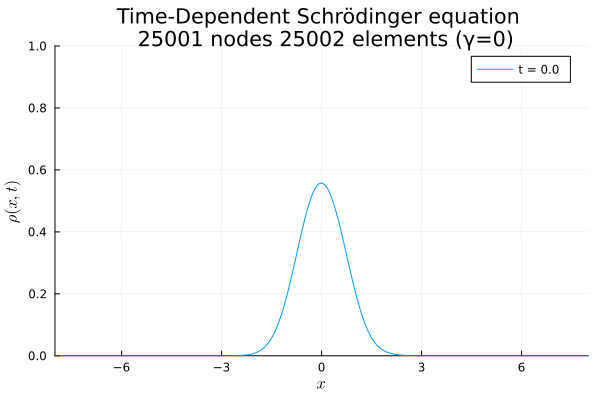

┌ Info: Saved animation to 
│   fn = /tmp/jl_YPYBo3w7ol.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_YJeR0ti5uV.gif")
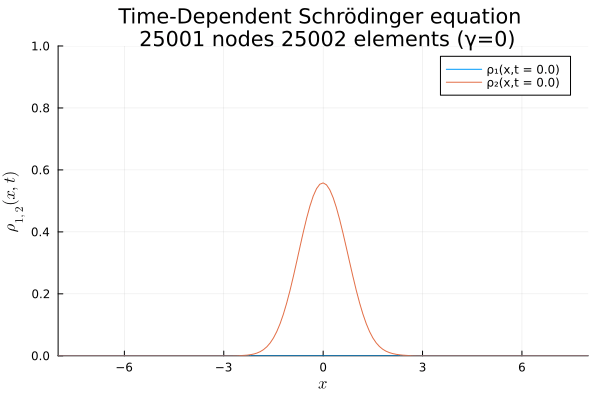

┌ Info: Saved animation to 
│   fn = /tmp/jl_YJeR0ti5uV.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


In [33]:
if (γ==0)
    anim₁ = @animate for i in 1:10:length(time_vec)
        plot(x[:],ρ₁t[:,i].+ρ₂t[:,i],label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-8,8))
    end

    anim₂ = @animate for i in 1:10:length(time_vec)
        plot(x,ρ₁t[:,i],label="ρ₁(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(x,ρ₂t[:,i],label="ρ₂(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho_{1,2}(x,t)\$")
    end

    display(gif(anim₁,fps=70))
    display(gif(anim₂,fps=70))
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_01.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_02.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_02.gif")
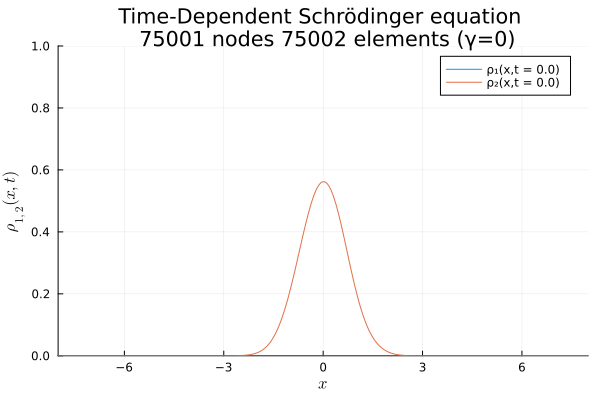

In [108]:
if (γ==0)
    anim₁ = @animate for i in 1:10:length(time_vec)
        plot(x[:],ρ₁t[:,i].+ρ₂t[:,i],label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 75001 nodes 75002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-8,8))
    end

    anim₂ = @animate for i in 1:10:length(time_vec)
        plot(x,ρ₁t[:,i],label="ρ₁(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(x,ρ₂t[:,i],label="ρ₂(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 75001 nodes 75002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho_{1,2}(x,t)\$")
    end

    gif(anim₁, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_01.gif", fps = 70)
    gif(anim₂, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_02.gif", fps = 70)
end

┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_03.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


┌ Info: Saved animation to 
│   fn = /home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_04.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/home/mendez/github_repositories/my_repositories/pde2022/final_project/codes/plots/animation_TimeDependetSchrodEquat_withoutgamma_04.gif")
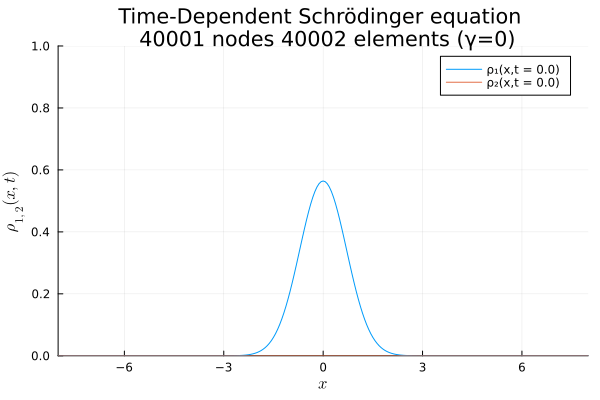

In [26]:
if (γ==0)
    anim₁ = @animate for i in 1:10:length(time_vec)
        plot(x[:],ρ₁t[:,i].+ρ₂t[:,i],label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 40001 nodes 40002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-8,8))
    end

    anim₂ = @animate for i in 1:10:length(time_vec)
        plot(x,ρ₁t[:,i],label="ρ₁(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(x,ρ₂t[:,i],label="ρ₂(x,t = $(round(time_vec[i]; digits=4)))",ylim=(0,1),xlim=(-8,8))
        plot!(title="Time-Dependent Schrödinger equation \n 40001 nodes 40002 elements (γ=0)",xlabel="\$x\$",ylabel="\$ \\rho_{1,2}(x,t)\$")
    end

    gif(anim₁, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_03.gif", fps = 70)
    gif(anim₂, path_plots*"animation_TimeDependetSchrodEquat_withoutgamma_04.gif", fps = 70)
end

### 8.2 Testeamos los métodos para $\gamma \neq 0$

Chequemos normalización de la función de onda

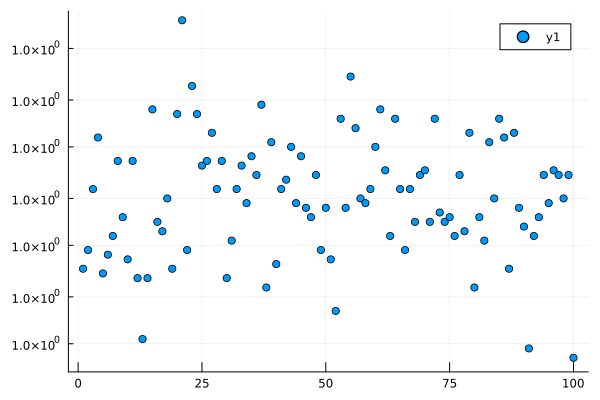

In [63]:
𝛹ₓₜ_norm=normalization_eigenstates_2D(𝛹ₓₜ,UHreim_1D,dΩ_1D);
scatter(𝛹ₓₜ_norm)

#### Resultado para la corrida usando `CoeffInitCondOptimized(...)`

Resultados para una configuración de

+ $\Delta x = 0.000667$ ($75002$ elements)
+ $\Delta t = 0.194444$
+ Number steps $= 541$

┌ Info: Saved animation to 
│   fn = /tmp/jl_Wbs50DmLeb.gif
└ @ Plots /home/mendez/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_Wbs50DmLeb.gif")
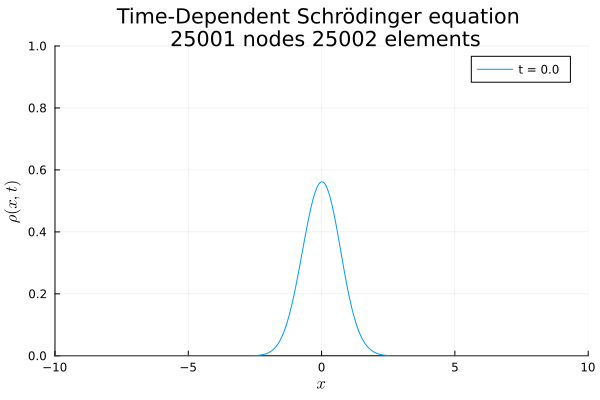

In [55]:
anim₁ = @animate for i in 1:length(time_vec)
    ρ₁Hreim_1D=real(conj(𝛹ₓₜ[i][1].(pts)).*𝛹ₓₜ[i][1].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    ρ₂Hreim_1D=real(conj(𝛹ₓₜ[i][2].(pts)).*𝛹ₓₜ[i][2].(pts)) #./ (𝛹ₓₜ_norm[i]^2)

    plot(x[:],ρ₁Hreim_1D+ρ₂Hreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-10,10))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-10,10))
end

gif(anim₁, fps = 10)

Resultados obtenidos usando MCTDH

<video controls width="500">
  <source src="./videos/MCTDH_simulation_screencast.mp4" type="video/mp4" />
</video>

Creamos una función para calcular la población de ambas coordenadas de la función de onda

Una vez obtenido el operador densidad podremos calcular las probabilidades de que una dada partícula esté en un volumen $V$ para un dado tiempo $t$ de la siguiente manera,

\begin{align}
    p( t) =\int _{V} \rho (\vec{x} ,t) dV
\end{align}

y numéricamente tendremos

\begin{align}
    p_{k}( t_{j}) =\mathrm{sum}\left(\int _{\Omega }[ u_{k}( x_{i} ,t_{j})]^{*} u_{k}( x_{i} ,t_{j}) d\Omega \right) ;\ k=\{1,2\}
\end{align}

$^{\ddagger }$ Wikipedia contributors, "Probability amplitude," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Probability_amplitude&oldid=1120547317 (accessed February 11, 2023).

In [41]:
function Populations_2D(𝛹ₓₜ,TrialSpace,dΩ)
    dimₜ=length(𝛹ₓₜ)
    p¹ₜ=zeros(Float64,dimₜ);
    p²ₜ=zeros(Float64,dimₜ);

    for i in 1:dimₜ
        𝛹ₓₜᵢ=interpolate_everywhere(𝛹ₓₜ[i],TrialSpace);
        𝛹¹ₓₜᵢ,𝛹²ₓₜᵢ=𝛹ₓₜᵢ
        norm_𝛹¹ₓₜᵢ=norm_L2(𝛹¹ₓₜᵢ,dΩ)
        norm_𝛹²ₓₜᵢ=norm_L2(𝛹²ₓₜᵢ,dΩ)
        p¹ₜ[i]=real(sum(∫(𝛹¹ₓₜᵢ'*𝛹¹ₓₜᵢ)*dΩ))/(norm_𝛹¹ₓₜᵢ)
        p²ₜ[i]=real(sum(∫(𝛹²ₓₜᵢ'*𝛹²ₓₜᵢ)*dΩ))/(norm_𝛹²ₓₜᵢ)
    end

    return p¹ₜ,p²ₜ;
end

Populations_2D (generic function with 1 method)

In [42]:
p₁H_1D,p₂H_1D=Populations_2D(𝛹ₓₜ,UHreim_1D,dΩ_1D); # calculamos poblaciones

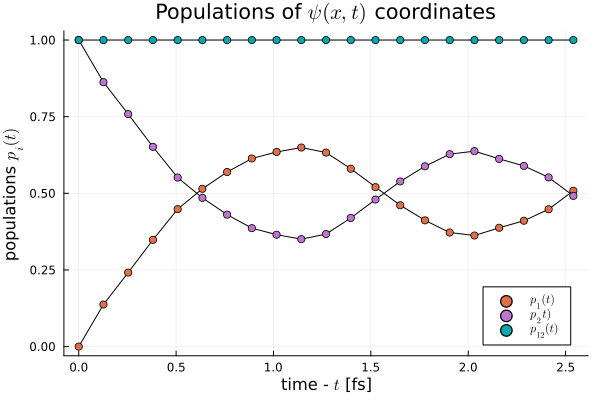

In [52]:
plotting=true
if plotting
    plot1=plot(time_vec .* 0.02418884,p₁H_1D,label="",lw=1,lc="black")
    plot1=scatter!(time_vec .* 0.02418884,p₁H_1D,label="\$p_{1}(t)\$")
    plot1=plot!(time_vec .* 0.02418884,p₂H_1D,label="",lw=1,lc=:"black")
    plot1=scatter!(time_vec .* 0.02418884,p₂H_1D,label="\$p_{2}t)\$")
    plot1=plot!(time_vec .* 0.02418884,(p₁H_1D .+ p₂H_1D),label="",lw=1,lc=:"black")
    plot1=scatter!(time_vec .* 0.02418884,(p₁H_1D .+ p₂H_1D),label="\$p_{12}(t)\$")
    plot1=plot!(title="Populations of \$\\psi(x,t)\$ coordinates",xlabel="time - \$t\$ [fs]",ylabel="populations \$p_{i}(t)\$")
    # plot1=plot!(yaxis=:log,minorticks=:auto,legend=:bottomright)
    plot1=plot!(legend=:bottomright)

    display(plot1);
    # savefig(plot1,path_plots*"population_wfcoord.pdf");
end

Y ahora comparamos este resultado con las ismulaciones de MCTDH

In [1]:
import Pkg; Pkg.add("PGFPlotsX");

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


Precompiling project...


  ✓ DiffEqBase


  ✓ DiffEqNoiseProcess


  ✓ JumpProcesses


  ✓ BoundaryValueDiffEq


  ✓ LoopVectorization


  ✓ DiffEqCallbacks


  ✓ SteadyStateDiffEq


  ✓ Sundials


  ✓ TriangularSolve


  ✓ RecursiveFactorization


  ✓ NonlinearSolve


  ✓ LinearSolve


  ✓ OrdinaryDiffEq


  ✓ DelayDiffEq


  ✓ StochasticDiffEq


  ✓ QuantumOptics


  ✓ DifferentialEquations


  17 dependencies successfully precompiled in 419 seconds. 337 already precompiled. 3 skipped during auto due to previous errors.


In [2]:
# Create a PDF struct that can be showed as inline svg
using PGFPlotsX

struct PDF
    file::String
    PDF(file) = new(abspath(file))
end
function Base.show(io::IO, ::MIME"image/svg+xml", pdf::PDF)
    svg = first(splitext(pdf.file)) * ".svg"
    #svg = splitext(pdf.file) * ".svg"
    PGFPlotsX.convert_pdf_to_svg(pdf.file, svg)
    write(io, read(svg))
    try; rm(svg; force=true); catch e; end
    return nothing
end

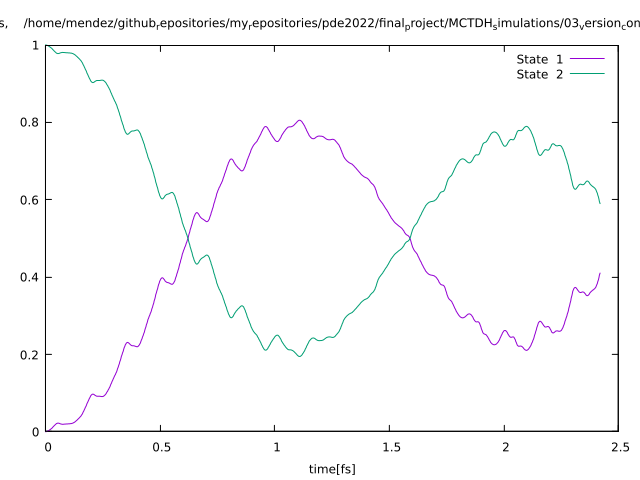

In [3]:
PDF("../MCTDH_simulations/03_version_components/plots/populatios_plstate.pdf")